# 讀入套件

In [1]:
#import basic package
%matplotlib inline
%env KERAS_BACKED=tensorflow
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import matplotlib.pyplot as plt
import os
import keras
import h5py
import librosa
import librosa.display
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from ipywidgets import interact
import math

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization

env: KERAS_BACKED=tensorflow


Using TensorFlow backend.


# 讀入處理好的音樂片段與分類(皆為一維)

In [2]:
X = np.load('all_signal_list0_13.npy')
y = np.load('all_cat_list.npy')

### 取一首歌的長度(一首歌的形狀為128*129*1=16512)，一首歌會被分為19個檔案，這邊呈現的是梅爾頻譜取對數之後所呈現的音頻的特徵值

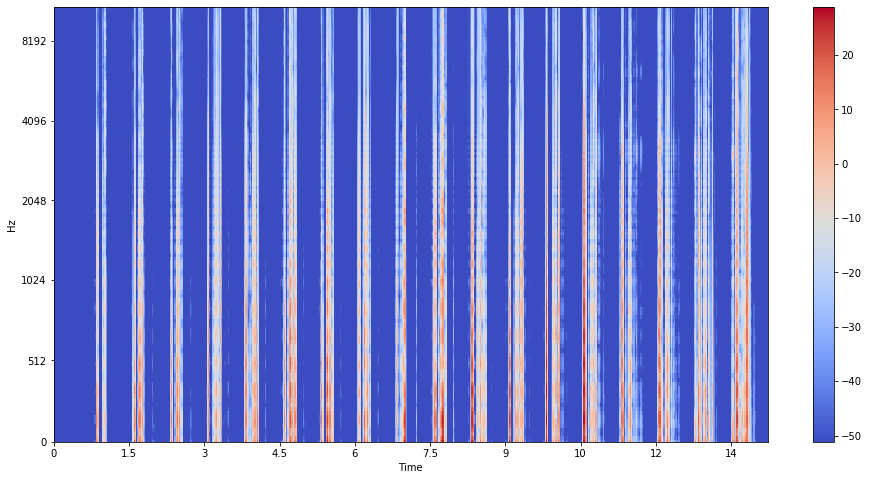

In [3]:
x = X[:313728]
sr=22050
melspec = librosa.feature.melspectrogram(x, sr, n_fft=1024, hop_length=512, n_mels=128)
logmelspec = librosa.power_to_db(melspec)
plt.figure(figsize=(16,8))
librosa.display.specshow(logmelspec, x_axis='time', y_axis='mel')
plt.colorbar()

## 將歌曲陣列還原成原本的維度，並將y進行one-hot encoding

In [5]:
X = X.reshape(79097,128,129,1)
X.shape,y.shape

((79097, 128, 129, 1), (79097,))

In [6]:
y = to_categorical(y)
y.shape

(79097, 14)

## 分割訓練與驗證資料

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(55367, 128, 129, 1) (23730, 128, 129, 1) (55367, 14) (23730, 14)


## 資料分割後的視覺化

<BarContainer object of 14 artists>

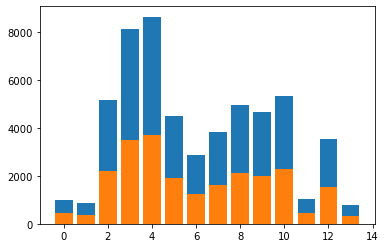

In [9]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)

# 建立CNN預測模型

In [15]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 14

model = Sequential()
# Conv Block 1
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Conv Block 4
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# MLP
model.add(Flatten())
model.add(Dense(num_genres, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 127, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
__________

## 進行compile並開始訓練，值得一提的是這邊使用binary  crossentropy可以得到非常卓越的預測效果

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=2000,
          epochs=30,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 55367 samples, validate on 23730 samples
Epoch 1/30
55367/55367 [==============================] - 540s 10ms/step - loss: 0.2865 - acc: 0.9245 - val_loss: 0.2436 - val_acc: 0.9286
Epoch 2/30
55367/55367 [==============================] - 538s 10ms/step - loss: 0.2323 - acc: 0.9283 - val_loss: 0.2293 - val_acc: 0.9285
Epoch 3/30
55367/55367 [==============================] - 532s 10ms/step - loss: 0.2223 - acc: 0.9281 - val_loss: 0.2212 - val_acc: 0.9286
Epoch 4/30
55367/55367 [==============================] - 532s 10ms/step - loss: 0.2153 - acc: 0.9285 - val_loss: 0.2131 - val_acc: 0.9288
Epoch 5/30
55367/55367 [==============================] - 534s 10ms/step - loss: 0.2108 - acc: 0.9289 - val_loss: 0.2098 - val_acc: 0.9293
Epoch 6/30
55367/55367 [==============================] - 531s 10ms/step - loss: 0.2075 - acc: 0.9292 - val_loss: 0.2070 - val_acc: 0.9295
Epoch 7/30
55367/55367 [==============================] - 534s 10ms/step - loss: 0.2049 - acc: 0.9298 - val_loss: 0.

In [19]:
score = model.evaluate(X_test, y_test)

23730/23730 [==============================] - 94s 4ms/step


In [20]:
print('loss:', score[0])
print('正確率', score[1]*100)

loss: 0.17470048294758625
正確率 93.59881364289487


## 跑完訓練準確率可達約93.6%，傑出的一手。將權重存起來

In [52]:
model_json = model.to_json()
open('genre_model.json', 'w').write(model_json)
model.save_weights('genre_model_weights.h5')

# 訓練過程視覺化

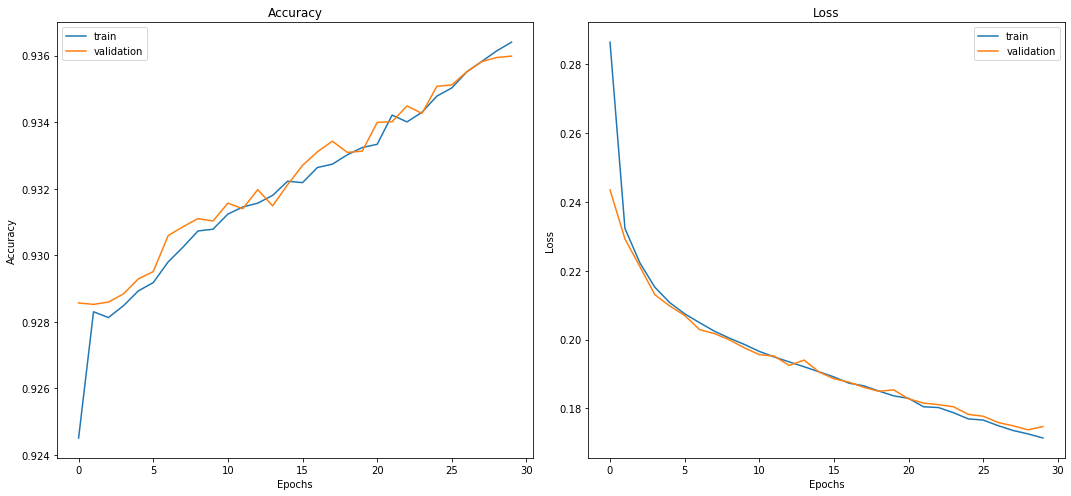

In [21]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()